# Content

En esta Notebook, nos concentramos en la extracción de features de la imagen de content. La motivación detras de este notebook era pedagogica y personal, para comprobar que entendía el artículo y la implementación propuesta en la notebook del trabajo final, quise reproducir cada figura del artículo. Este notebook y el notebook asociado de estilo están destinado a reproducir la figura 1 del articulo origional (ver abajo). 





In [1]:
# Creamos el directorio para los archivos de salida
#!mkdir /content/output
folder = 'D:/Marc/Anaconda/Trabajo _final_Computer_Vision/content/'
base_image_path = f'{folder}Tuebingen_Neckarfront.jpg'

In [2]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from keras.applications import vgg19
from keras import backend as K
from pathlib import Path
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [3]:
# Definimos las imagenes que vamos a utilizar, y el directorio de salida

result_prefix = f'{folder}/output/content_from_noise_block5_conv2_TV/'
iterations = 30

In [4]:
total_variation_weight = 0.02
content_weight = 1

In [5]:
# Definimos el tamaño de las imágenes a utilizar
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)
noise_matrix = np.random.uniform(0,255,size=(height,width,3))
noise = np.clip(noise_matrix, 0, 255).astype('uint8')
save_img(f'{folder}white_noise_image.jpg',noise)
noise_image_path = f'{folder}white_noise_image.jpg'

In [6]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [7]:
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [8]:
# get tensor representations of our images
# K.variable convierte un numpy array en un tensor, para 
base_image = K.variable(preprocess_image(base_image_path))

In [9]:
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

In [10]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,combination_image], axis=0)

In [11]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

Model loaded.


In [12]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))


In [13]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


In [14]:
# Armamos la loss total
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[1, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,combination_features)
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [15]:
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

In [16]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

In [17]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

Start of iteration 0
Current loss value: 498493200.0
Image saved as D:/Marc/Anaconda/Trabajo _final_Computer_Vision/content//output/content_from_noise_block5_conv2_TV/output_at_iteration_0.png
Iteration 0 completed in 71s
Start of iteration 1
Current loss value: 240050910.0
Image saved as D:/Marc/Anaconda/Trabajo _final_Computer_Vision/content//output/content_from_noise_block5_conv2_TV/output_at_iteration_1.png
Iteration 1 completed in 73s
Start of iteration 2
Current loss value: 156997460.0
Image saved as D:/Marc/Anaconda/Trabajo _final_Computer_Vision/content//output/content_from_noise_block5_conv2_TV/output_at_iteration_2.png
Iteration 2 completed in 75s
Start of iteration 3
Current loss value: 120079910.0
Image saved as D:/Marc/Anaconda/Trabajo _final_Computer_Vision/content//output/content_from_noise_block5_conv2_TV/output_at_iteration_3.png
Iteration 3 completed in 74s
Start of iteration 4
Current loss value: 98447390.0
Image saved as D:/Marc/Anaconda/Trabajo _final_Computer_Visi

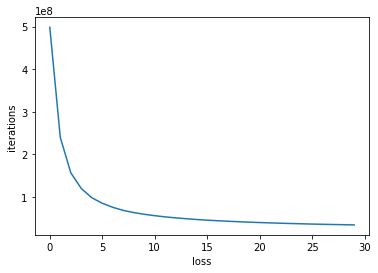

In [18]:
evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
# x = preprocess_image(base_image_path)
x = preprocess_image(noise_image_path)
loss_graficar = []

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    loss_graficar.append(min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    # fname = result_prefix / ('output_at_iteration_%d.png' % i)
    d = i
    fname = f'{result_prefix}output_at_iteration_{d}.png'
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
    
plt.plot(loss_graficar)
plt.xlabel('loss')
plt.ylabel('iterations')
plt.savefig(f'{result_prefix}loss_graficar.png')
plt.show() 

Discusión
El objectivo de este notebook auxiliar es entender el input provisto por la image_content. En particular vamos a reconstruir las dos últimas imagens de la fila inferior en la imagen adjunta sacado del artículo, pues es la que utilizamos en el notebook principal. En este caso, como utilisamos solamente la loss de content y que  esta es simple la diferencia entre la combination image y content_image, la diferencia es nula si utiliso como punto de partida la imagen de contenido (la deje comentada arriba y uno puede probar intercambiando x si no esta convencido; va a encontrar que la imagen no sufre modificaciones). Por eso se utiliza la imagen de ruido blanco uniformo como input. El precio a pagar es que inevitablemente el resultado final tendra una estructura local mas pixelizada. Por eso se deja la possibilidad de utilizar total_variation_loss que solamente afecta las estructura local para dar una imagen mas suave al nivel local. 

Figura 1 del artículo original.

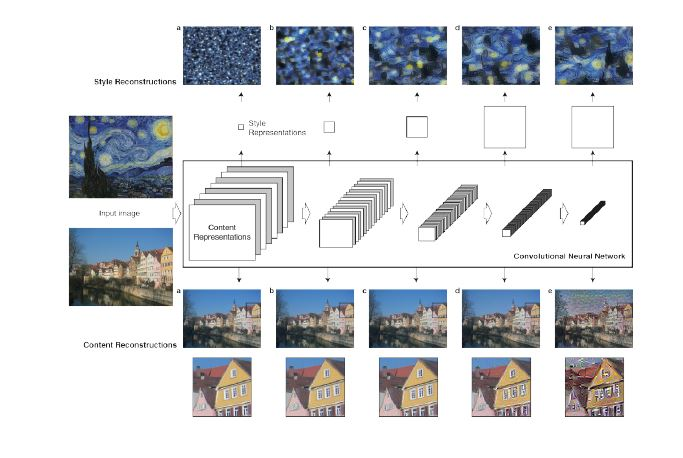

layer of VGG-net19: block4_conv2

Loss: content_loss

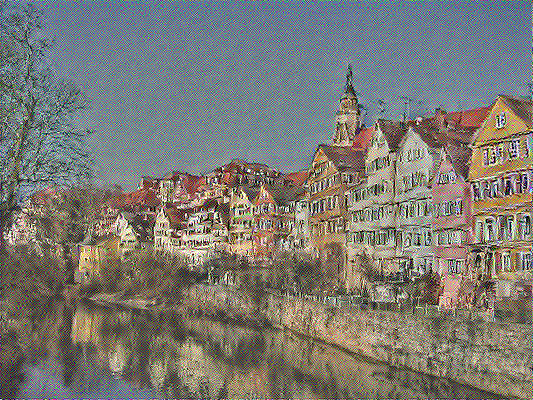

layer of VGG-net19: block4_conv2

Loss: content_loss + 1 x total_variation_loss

Se verifica que la total_variation_loss suavisa eñ resultado final. Dicho de otra forma, estructura de frecuencias espaciales altas son eliminadas.  

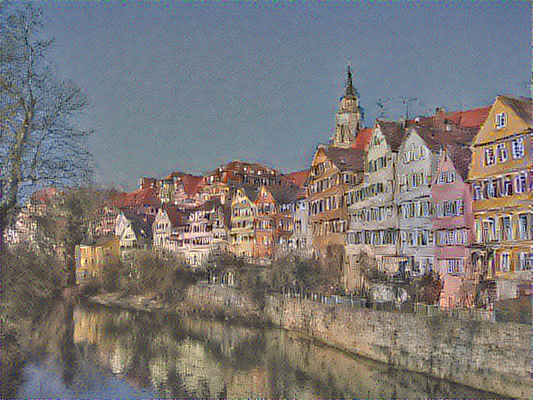

layer of VGG-net19: Block5_conv1

Loss: content_loss + 0.04 x total_variation_loss

En este caso, miramso a uan salida mas profunda de la VGG-net19 que abarca area mas lejana que provoca cambio mas brusco a varais escalas. Si mantenemos la total_variation_loss con un pespo granmde frente a la content loss, tendrems fusión de features a mas garnde escala espacial provocando una imagen demasiada borroneada y pro lo rtanto demasiada alejada a la estructura que queremos demonstrar; tal como en el artículo, el efecto deseado es puramente estetico para dar un resultado mas "lindo" pero queremos que sea representativo de la capa a visualizar; solamente queremso disminuir la pizelización proveniendo de la imagen de partida. 
    
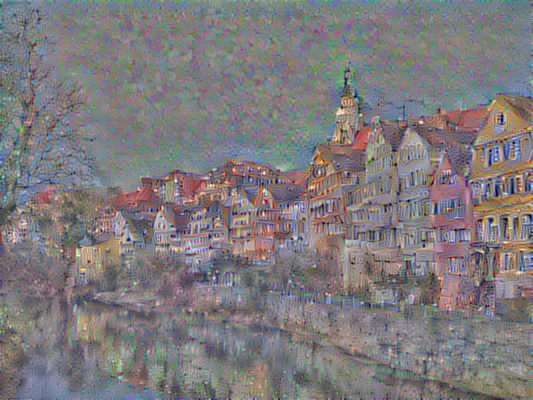

layer of VGG-net19: Block5_conv2
    
Loss: content_loss
    
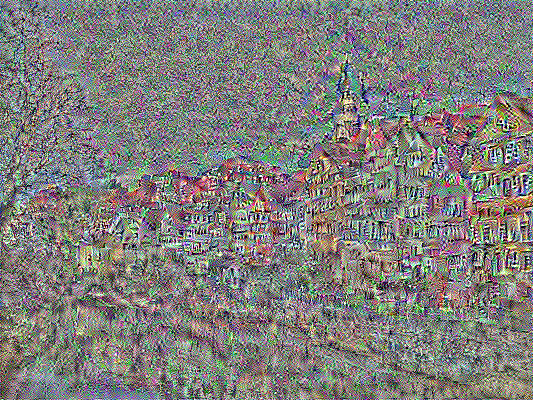

layer of VGG-net19: block5_conv2

Loss: content_loss + 0.02 x total_variation_loss

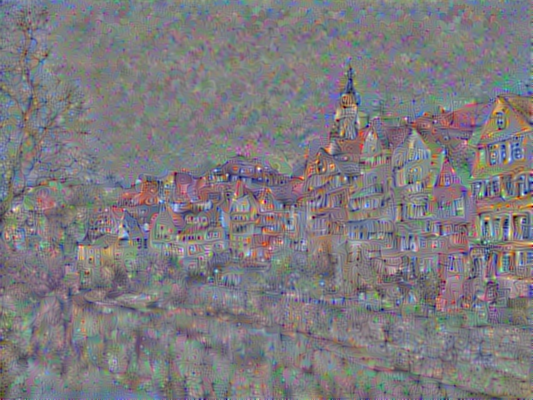